# Regression: Predicting Rental Price

In this notebook, we will use the dataset we cleansed in the previous lab to predict Airbnb rental prices in San Francisco.

## In this lesson you:
 - Use the python to build a linear regression model
 - Identify the differences between estimators and transformers

In [1]:
# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# cartographie
import folium
from folium import plugins
from folium.plugins import HeatMap
import geopandas

Output_path = 'C:/Users/Thierno Barry/Documents/Machine Learning/00.data/output/'
Iutput_path = 'C:/Users/Thierno Barry/Documents/Machine Learning/00.data/input/'

In [2]:
file_path = Iutput_path+"sf-listings-2019-03-06-clean_delta.csv"
airbnb_df = pd.read_csv(file_path)

## Train/Test Split

![](https://files.training.databricks.com/images/301/TrainTestSplit.png)

**Question**: Why is it necessary to set a seed? What happens if I change my cluster configuration?

In [70]:
train_df, test_df = train_test_split(airbnb_df, test_size=0.2, random_state=42)
display(train_df.shape[0])
display(test_df.shape[0])

5716

1430

Let's change the # of partitions, and see if we get the same number of data points in our training set.

In [71]:
# Sélection aléatoire de 80% des données pour l'entraînement
#train_df = airbnb_df.sample(frac=0.8, random_state=42)

# Suppression des lignes sélectionnées pour obtenir le DataFrame de test
#test_df = airbnb_df.drop(train_df.index)

# Réinitialisation des index pour le DataFrame de train
#train_df = train_df.reset_index(drop=True)

#print(train_df.shape[0])

## Linear Regression

We are going to build a very simple model predicting **`price`** just given the number of **`bedrooms`**.

**Question**: What are some assumptions of the linear regression model?

In [72]:
display(train_df[["price", "bedrooms"]])

,price,bedrooms
59,119,1
3717,500,2
787,190,1
2540,265,3
6225,191,1
...,...,...
3772,98,1
5191,110,1
5226,495,4
5390,149,1


Text(0, 0.5, 'bedrooms')

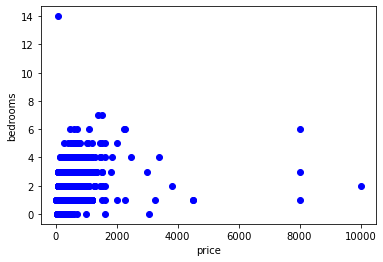

In [73]:
plt.scatter(train_df['price'], train_df['bedrooms'], c = 'blue')
plt.xlabel('price')
plt.ylabel('bedrooms')

In [74]:
display(train_df[["price", "bedrooms"]].describe())

,price,bedrooms
count,5716.000000,5716.000000
mean,214.282015,1.346046
std,316.255794,0.936246
min,10.000000,0.000000
25%,100.000000,1.000000
50%,150.000000,1.000000
75%,235.000000,2.000000
max,10000.000000,14.000000


In [75]:
display(train_df)

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,bedrooms_na,bathrooms_na,beds_na,review_scores_rating_na,review_scores_accuracy_na,review_scores_cleanliness_na,review_scores_checkin_na,review_scores_communication_na,review_scores_location_na,review_scores_value_na
59,t,moderate,t,2,Mission,37.74994,-122.41452,House,Private room,3,...,0,0,0,0,0,0,0,0,0,0
3717,t,moderate,f,2,Castro/Upper Market,37.76159,-122.44491,Condominium,Entire home/apt,4,...,0,0,0,1,1,1,1,1,1,1
787,t,moderate,f,3,Mission,37.75011,-122.41680,House,Private room,2,...,0,0,0,0,0,0,0,0,0,0
2540,f,strict_14_with_grace_period,f,1,Marina,37.80031,-122.43142,Serviced apartment,Entire home/apt,6,...,0,0,0,0,0,0,0,0,0,0
6225,f,strict_14_with_grace_period,f,33,Nob Hill,37.79669,-122.41223,Condominium,Entire home/apt,2,...,0,0,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,t,moderate,f,2,Noe Valley,37.74833,-122.42501,House,Private room,2,...,0,0,0,0,0,0,0,0,0,0
5191,t,strict_14_with_grace_period,f,3,Western Addition,37.77729,-122.43421,Townhouse,Private room,2,...,0,0,0,0,0,0,0,0,0,0
5226,t,strict_14_with_grace_period,f,3,Outer Sunset,37.74984,-122.50852,House,Entire home/apt,11,...,0,0,0,0,0,0,0,0,0,0
5390,t,moderate,t,2,Inner Richmond,37.77717,-122.46757,House,Private room,2,...,0,0,0,0,0,0,0,0,0,0


There does appear to be some outliers in our dataset for the price ($10,000 a night??). Just keep this in mind when we are building our models.

We will use <a href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegression.html?highlight=linearregression#pyspark.ml.regression.LinearRegression" target="_blank">LinearRegression</a> to build our first model.

The cell below will fail because the Linear Regression estimator expects a vector of values as input. We will fix that with VectorAssembler below.

In [76]:
from sklearn.linear_model import LinearRegression

X_train = train_df[['bedrooms']]
y_train = train_df['price']

lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

In [77]:
vec_train_df = train_df.copy()
vec_train_df["features"] = vec_train_df["bedrooms"]

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X_train = train_df[["bedrooms"]]
y_train = train_df["price"]

# transformation des features avec polynomial features
poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train)

# création et entraînement du modèle
lr = LinearRegression()
lr_model = lr.fit(X_train_poly, y_train)

## Inspect the model

In [79]:
X = train_df["bedrooms"]
y = train_df["price"]
m, b = np.polyfit(X, y, 1)
print(f"The formula for the linear regression line is y = {m:.2f}x + {b:.2f}")

The formula for the linear regression line is y = 121.43x + 50.83


C:\Users\THIERN~1\AppData\Local\Temp/ipykernel_226600/1884214726.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(train_df['price'], train_df['bedrooms'], 'ro', markersize=4, c = 'blue')


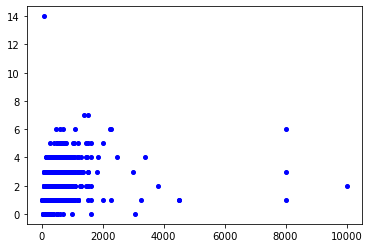

In [80]:
# On affiche le nuage de points dont on dispose
plt.plot(train_df['price'], train_df['bedrooms'], 'ro', markersize=4, c = 'blue')
plt.show()

In [81]:
# On décompose le dataset et on le transforme en matrices pour pouvoir effectuer notre calcul
X = np.matrix([np.ones(train_df.shape[0]), train_df['bedrooms'].values]).T
y = np.matrix(train_df['price']).T

In [82]:
# On effectue le calcul exact du paramètre theta
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(theta)

[[ 50.83267983]
 [121.42921784]]


In [83]:
from scipy.stats import linregress

x = train_df["bedrooms"]
y = train_df["price"]

slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(f"The p-value for the slope coefficient is: {p_value:.4f}")


The p-value for the slope coefficient is: 0.0000


In [84]:
print(f"The intercept for the slope coefficient is: {intercept:.4f}")

The intercept for the slope coefficient is: 50.8327


In [85]:
print(f"The slope coefficient is: {slope:.4f}")

The slope coefficient is: 121.4292


## Apply model to test set

In [94]:
#X_test = test_df["bedrooms"]
#y_test = test_df["price"]
#y_pred = lr.predict(X_test.values.reshape(-1, 1))

In [89]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(airbnb_df["bedrooms"], airbnb_df["price"], test_size=0.2, random_state=42)

# Créer un objet LinearRegression
lr = LinearRegression()

# Entraîner le modèle sur l'ensemble d'entraînement
lr.fit(X_train.values.reshape(-1, 1), y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = lr.predict(X_test.values.reshape(-1, 1))

# Évaluer les performances du modèle
print("R2 score :", r2_score(y_test, y_pred))
print("MSE :", mean_squared_error(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test, y_pred))

R2 score : 0.1342515577376775
MSE : 73324.07101734044
MAE : 102.47721295994386


In [90]:
pred_df = pd.DataFrame({"bedrooms": X_test, "price": y_test, "prediction": y_pred})
display(pred_df[["bedrooms", "price", "prediction"]])

,bedrooms,price,prediction
4147,1,120,172.261898
6601,2,315,293.691116
1859,0,180,50.832680
3050,1,115,172.261898
6983,1,109,172.261898
...,...,...,...
5642,1,300,172.261898
1483,1,98,172.261898
4010,1,140,172.261898
1488,1,180,172.261898


In [91]:
display(pred_df[pred_df['price'] == 86])

,bedrooms,price,prediction
1683,0,86,50.832680
4921,0,86,50.832680
1425,0,86,50.832680
248,1,86,172.261898
5602,0,86,50.832680
4564,1,86,172.261898


Text(0, 0.5, 'prediction')

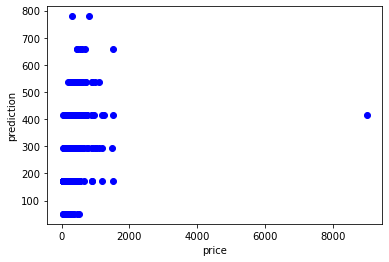

In [92]:
# On affiche le nuage de points dont on dispose
plt.scatter(pred_df['price'], pred_df['prediction'], c = 'blue')
plt.xlabel('price')
plt.ylabel('prediction')

In [95]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(pred_df['price'], pred_df['prediction'], squared=False)
print(f"RMSE is {rmse}")

RMSE is 270.7841779302115


In [97]:
from sklearn.metrics import r2_score

# Calculate R2 for average prediction
r2 = r2_score(pred_df['price'], pred_df['prediction'])
print(f"The R2 for predicting the average price is: {r2}")

The R2 for predicting the average price is: 0.1342515577376775
